In [24]:
import numpy as np
import copy
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point
import random
from shapely import affinity
import matplotlib.pyplot as plt
import time

In [25]:
class Room():        
    def __init__(self, shape):
        self.shape = shape
        self.polygon = Polygon(np.array(shape, dtype=np.float64))

In [26]:
class FurnitureItem(): 
    def __init__(self, unitcost, shape):
        self.shape = shape
        self.unit_cost = unitcost
        self.polygon = Polygon(np.array(shape, dtype=np.float64))
        self.total_cost = np.float64((np.float64(self.unit_cost) * self.polygon.area))
        self.sorting = (self.polygon, self.polygon.area)

In [27]:
class Problem():
    def __init__(self, room, furniture):
        self.room = room
        self.furniture = furniture

In [28]:
problems = []
with open('problems.rfp') as f:
    for line in f:
        furnitureList = []
        problem = line.replace(" ","").split("#")

        room_shape = problem[0].split(":")[1]
        furniture = problem[1].split(";")

        room = Room([tuple(np.float64(i) for i in el.strip('()').split(',')) for el in room_shape.split('),(')])

        for furnitureItem in furniture:
            parse_furniture = furnitureItem.strip().split(":")
            unit_cost = parse_furniture[0]
            shape = [tuple(np.float64(i) for i in el.strip('()').split(',')) for el in parse_furniture[1].split('),(')]
            furnitureItem = FurnitureItem(unit_cost, shape)
            furnitureList.append(furnitureItem)
        problems.append(Problem(room,furnitureList))

In [29]:
def plot(poly):
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.show()

In [30]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points

In [31]:
shapeFuck = Polygon([(-1.520878428822382, 0.05762291911687356), (-2.068385058693476, -0.05523314074344998), (-2.2230288086118244, 0.14119829923292293), (-1.984809678577427, 0.6469172390459922), (-2.5323163084485207, 0.5340611791856684), (-2.686960058366869, 0.7304926191620414), (-2.4487409283324713, 1.2362115589751108), (-2.9962475582035655, 1.123355499114787), (-3.1508913081219134, 1.3197869390911598), (-2.912672178087516, 1.8255058789042293), (-3.853041687911356, 1.4033623192072089), (-2.3066041887278734, -0.5609520805565194),(-1.520878428822382, 0.05762291911687356)])
new_room = problems[10].room.polygon.difference(shapeFuck)

In [9]:
solution = []
room_2 = problems[10].room.polygon
shapes = copy.copy(problems[10].furniture)
initial_area = room_2.area
room_2 = new_room
while (room_2.area) > initial_area*0.7:
    while(room_2.area > 76):
        for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4:
                points = random_points_within(room_2,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if room_2.contains(polygon):
                    room_2 = room_2.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (room_2.area))

    for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4 or len(x)==5:
                points = random_points_within(room_2,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if room_2.contains(polygon):
                    room_2 = room_2.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (room_2.area))
room_2.area

499 89.12499999999991
498 87.62499999999991


KeyboardInterrupt: 

In [32]:
output = ""
for x in solution:
    output = output + str(x[:-1]).replace('[','').replace(']','') + "; "
print(output)

(-7.0899292179403695, -9.507298651950242), (-6.254034268636981, -6.583041543943307), (-7.993153417872167, -9.078129635527148); (-12.656996203274852, 1.8231279303938428), (-10.44838911872235, -0.26781796705652017), (-11.85946742115298, 2.4264088282243645); 


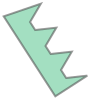

In [33]:
test = Polygon()
for item in problems[10].furniture:
    x, y = item.polygon.exterior.xy
    if(len(x) == 13):
        test = item
        break
test.polygon

In [34]:
import pickle as cPickle
with open("output.pkl", "rb") as input:
    shape13 = cPickle.load(input)


In [35]:
shape13

'(-1.520878428822382, 0.05762291911687356), (-2.068385058693476, -0.05523314074344998), (-2.2230288086118244, 0.14119829923292293), (-1.984809678577427, 0.6469172390459922), (-2.5323163084485207, 0.5340611791856684), (-2.686960058366869, 0.7304926191620414), (-2.4487409283324713, 1.2362115589751108), (-2.9962475582035655, 1.123355499114787), (-3.1508913081219134, 1.3197869390911598), (-2.912672178087516, 1.8255058789042293), (-3.853041687911356, 1.4033623192072089), (-2.3066041887278734, -0.5609520805565194); '

In [36]:
shapeFuck = Polygon([(-1.520878428822382, 0.05762291911687356), (-2.068385058693476, -0.05523314074344998), (-2.2230288086118244, 0.14119829923292293), (-1.984809678577427, 0.6469172390459922), (-2.5323163084485207, 0.5340611791856684), (-2.686960058366869, 0.7304926191620414), (-2.4487409283324713, 1.2362115589751108), (-2.9962475582035655, 1.123355499114787), (-3.1508913081219134, 1.3197869390911598), (-2.912672178087516, 1.8255058789042293), (-3.853041687911356, 1.4033623192072089), (-2.3066041887278734, -0.5609520805565194),(-1.520878428822382, 0.05762291911687356)])

In [12]:
room_11 = problems[10].room.polygon
furniture_items_13 = []

for item in problems[10].furniture:
    x,y = item.polygon.exterior.xy
    if(len(x)==13):
        furniture_items_13.append(item.polygon)

In [143]:
%matplotlib inline
import pandas as pd
from IPython import display

roomX,roomY = problems[10].room.polygon.exterior.xy
x, y = (-15.263873846963547, 6.635182712924597)
z= 0
for item in furniture_items_13:
    print(z)
    itemExX,itmeExY = item.exterior.xy
    #Example starting with specific vertex
    shapeCoordinates = list(zip(*(itemExX,itmeExY)))
    (shapeX, shapeY) = shapeCoordinates[10]
    trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
    #Example starting already at 290
    for i in range(290,360):
        rotated_trans_shape = affinity.rotate(trans_shape, i, origin=(x, y))
        sX,sY = rotated_trans_shape.exterior.xy  
        plt.plot(rX, rY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
        plt.plot(sX, sY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
        display.display(plt.gcf())
        display.display(plt.clf())
        display.clear_output(wait=True)
        time.sleep(0.5)
        print(i)
            
            

KeyboardInterrupt: 

In [146]:
item = furniture_items_13[0]
itemExX,itmeExY = item.exterior.xy
x, y = (-15.263873846963547, 6.635182712924597)
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[10]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
rotated_trans_shape = affinity.rotate(trans_shape, 308, origin=(x, y))
room_11.

True